# CartoBlobPy Demo
This notebook shows how to load a map from the assets and check whether a straight line between two world points collides with obstacles using `Graph.is_free_path`.

In [1]:
# Setup: add repo root to Python path and import package
import sys, os
sys.path.append("../src")
from cartoblobpy.graph import Graph
from cartoblobpy.assets import get_map_path, list_example_maps

Available maps: ['map002.yaml', 'map004.yaml', 'map005.yaml', 'map006.yaml', 'map007.yaml', 'map008.yaml', 'map009.yaml', 'map010.yaml', 'map011.yaml', 'map012.yaml', 'map013.yaml', 'map014.yaml', 'map015.yaml']
Using map: C:\Users\emirc\OneDrive - NTNU\Projects\image_to_map\cartoblobpy\src\cartoblobpy\assets\map002.yaml


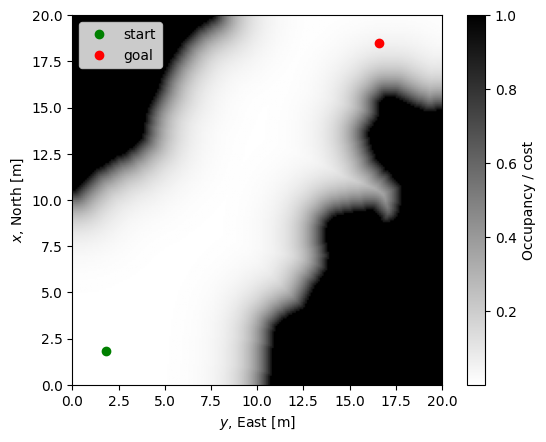

In [2]:
# Load a sample map from assets
available = list_example_maps()
print("Available maps:", available)
map_name = available[0] if available else 'map005.yaml'
yaml_path = get_map_path(map_name)
print("Using map:", yaml_path)

g = Graph()
g.coordinate_frame = "NED"  # or "ENU"
g.load_from_yaml(yaml_path)
g.inflate_obstacles(radius=1.0, use_world_units=True)  # 5 meters
ax = g.plot(cmap="gray_r")

Random world point: [12.   7.5]
Distance to shore (radius): 3.511409973215888 meters


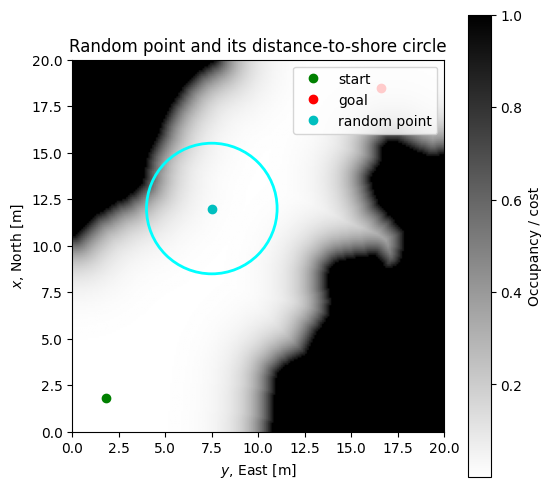

In [28]:
# Random point + circle (distance to shore)
import numpy as np
import matplotlib.pyplot as plt

W, H = g.real_width, g.real_height
x = 12.0
y = 7.5
rand_point_world = np.array([x, y])
print("Random world point:", rand_point_world)

radius_m = g.distance_to_closest_obstacle(rand_point_world)
print("Distance to shore (radius):", radius_m, "meters")

fig, ax = plt.subplots(figsize=(6, 6))
g.plot(ax=ax, cmap="gray_r", show_colorbar=True)

if g.coordinate_frame == "ENU":
    x_plot, y_plot = rand_point_world[0], rand_point_world[1]
else:  # NED world = [x_north, y_east] -> EN plotting plane = [x_east, y_north]
    x_plot, y_plot = rand_point_world[1], rand_point_world[0]

ax.plot(x_plot, y_plot, 'co', markersize=6, label='random point')

# Draw circle with radius equal to distance to shore (in meters)
circle = plt.Circle((x_plot, y_plot), radius_m, color='cyan', fill=False, linewidth=2)
ax.add_patch(circle)
ax.set_title("Random point and its distance-to-shore circle")
ax.legend(loc='upper right')
plt.show()